Celem laboratorium było zapoznanie się ze środowiskiem bibliotek języka Python, w szczególności z biblioteką opencv.
Jedno z zadan polegało na zbudowaniu modelu kolory skóry i wykorzystaniu go do segmentacji twarzy.
Drugie zadanie polegało na zbudowaniu modelu średniej twarzy i wykorzystaniu go jako wzorcu w template matchingu.

Importy:

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

Definicje pomocnicznych funkcji:

In [2]:
def frame_george_bush() -> np.array:
    filenames = [x[2] for x in os.walk('George_W_Bush')][0]
    images = [cv2.imread(f'George_W_Bush/{filename}') for filename in filenames]

    for image_iter, image in enumerate(images):
        framed_image = image[90:170, 90:170]

        images[image_iter] = framed_image
        cv2.imwrite(f'George_W_bush_framed/{filenames[image_iter]}', framed_image)

    return np.array(images)


def read_images(dir_name) -> np.array:
    filenames = [x[2] for x in os.walk(dir_name)][0]

    return np.array([cv2.imread(f'{dir_name}/{filename}') for filename in filenames])


def read_orl_images() -> np.array:
    filenames = [x[2] for x in os.walk('ORL')][0]

    return np.array([cv2.imread(f'ORL/{filename}', cv2.IMREAD_GRAYSCALE).astype(np.uint8) for filename in filenames])

Poniżej definicja funkcji dla zadania pierwszego.
Badane granice to indeks maksymalnego punktu wyliczonego z histogramu odjąć ten indeks podzielony przez 2.

In [3]:
def zad1():
    images = frame_george_bush()

    for image_iter, image in enumerate(images):
        image_y_cr_cb = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
        images[image_iter] = image_y_cr_cb

    hist_cb = cv2.calcHist(images, [1], None, [256], [0, 256])
    hist_cr = cv2.calcHist(images, [2], None, [256], [0, 256])

    max_index_cb = np.argmax(hist_cb)
    max_index_cr = np.argmax(hist_cr)

    plt.figure()
    plt.title('Histograms for George Bush')
    plt.plot(hist_cb, label=f'Cb, max={hist_cb[max_index_cb]}, max_index={max_index_cb}')
    plt.plot(hist_cr, label=f'Cr, max={hist_cr[max_index_cr]}, max_index={max_index_cr}')
    plt.legend()
    plt.show()

    cb_index_range = max_index_cb / 2
    cr_index_range = max_index_cr / 2

    people = ['Tony_Blair', 'Sharon_Frey', 'Joan_Claybrook', 'Alberta_Lee']
    cb_ranges = [max_index_cb - cb_index_range, max_index_cb + cb_index_range]
    cr_ranges = [max_index_cr - cr_index_range, max_index_cr + cr_index_range]

    for human in people:
        imaged = read_images(human)
        imaged = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB) for image in imaged])
        hist_cb_human = cv2.calcHist(imaged, [1], None, [256], cb_ranges)
        hist_cr_human = cv2.calcHist(imaged, [2], None, [256], cr_ranges)

        plt.figure()
        plt.title(f'Histograms for {human.replace("_", " ")}')
        plt.plot(hist_cb_human, label=f'Cb for ranges {"-".join(list(map(lambda x: str(x), cb_ranges)))}')
        plt.plot(hist_cr_human, label=f'Cr for ranges {"-".join(list(map(lambda x: str(x), cr_ranges)))}')
        plt.legend()
        plt.show()

Definicja funkcji dla zadania drugiego:

In [4]:
def zad2() -> None:
    images = read_orl_images()

    equal_fraction = 1.0 / images.shape[0]
    template_image = np.zeros_like(images[0])

    for img in images:
        template_image = template_image + img * equal_fraction

    template_image = template_image.astype(np.uint8)
    w = template_image.shape[-2]
    h = template_image.shape[-1]

    methods = {
        'TM_CCOEFF': cv2.TM_CCOEFF,
        'TM_CCOEFF_NORMED': cv2.TM_CCOEFF_NORMED,
        'TM_CCORR': cv2.TM_CCORR,
        'TM_CCORR_NORMED': cv2.TM_CCORR_NORMED,
        'TM_SQDIFF': cv2.TM_SQDIFF,
        'TM_SQDIFF_NORMED': cv2.TM_SQDIFF_NORMED,
    }
    images_names = ['28_3.jpg', '10_1.jpg', '84_9.jpg', '150_15.jpg', '186_19.jpg', '264_27.jpg', '316_32.jpg']

    for image_name in images_names:
        for method_name, method in methods.items():
            test_image = cv2.imread(f'ORL/{image_name}', cv2.IMREAD_GRAYSCALE)
            test_image = test_image.astype(np.uint8)

            # Apply template Matching
            res = cv2.matchTemplate(test_image, template_image, method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

            # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
            if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                top_left = min_loc
            else:
                top_left = max_loc

            bottom_right = (top_left[0] + w, top_left[1] + h)
            cv2.rectangle(test_image, top_left, bottom_right, 255, 1)

            plt.subplot(121), plt.imshow(template_image, cmap='gray')
            plt.title('Matching Template'), plt.xticks([]), plt.yticks([])
            plt.subplot(122), plt.imshow(test_image, cmap='gray')
            plt.title('Detected Face'), plt.xticks([]), plt.yticks([])
            plt.suptitle(f'Image {image_name}, Template matching method: {method_name}')
            plt.show()

Resultaty dla zadania numer 1:

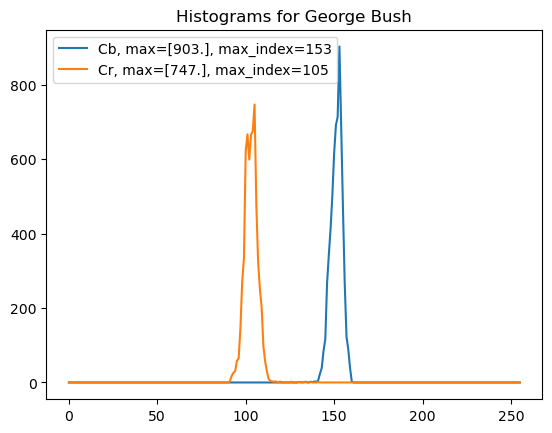

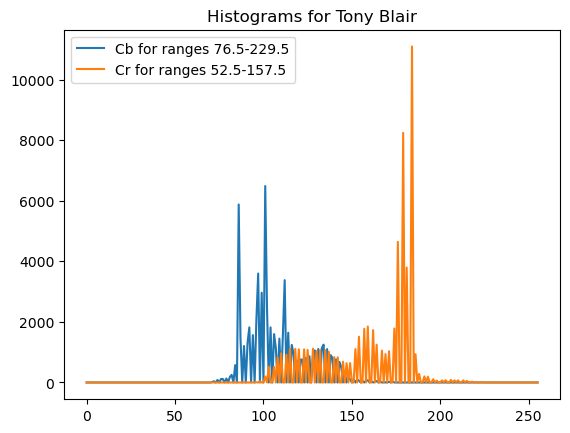

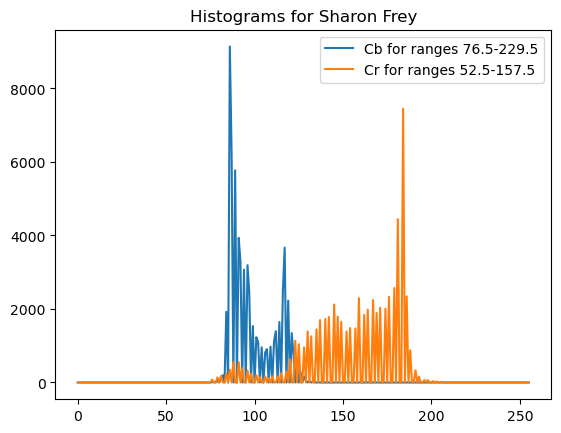

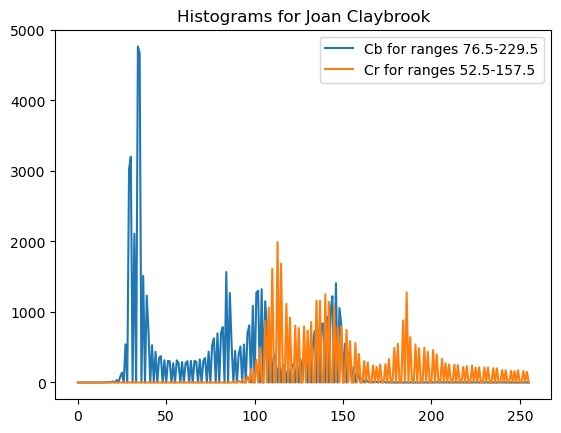

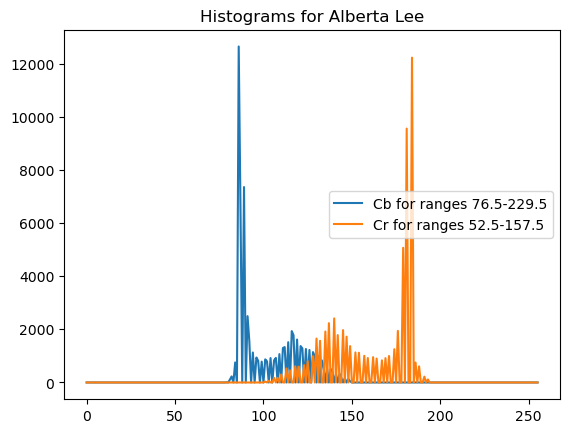

In [5]:
zad1()

Wnioski:
* Obrazy dla George Busha zostały wykadrowane na centrum obrazu, aby większą część obrazu stanowiła twarz. 
* Obrazy testowe nie zostały wykadrowane.
* Dla Cr histogram zawsze wychodzi poza maksymalną wartość zakresu, natomiast zawsze mieści się w minimalnej. Maksymalne wartości zazwyczaj kumulują się w okolicach około indeksu równego 180, czyli poza maksymalnym zakresem. Wyjątkiem jest Joan Claybrook, gdzie wartości są rozłożone po wykresie.
* Dla Cb maksymalne wartości histogramu zazwyczaj kumulują się w okolicach indeksu 100, jedynie dla Joan Claybrook wartości kumulują się w okolicach 40. Także wartości nie wychodzą poza minimalny zakres oprócz Joana Claybrooka. Wartości także nie wychodzą poza maksymalny zakres Cb.

Wykonanie i resultaty dla zadania numer 2.
Po lewej obraz wzorcowy, po prawej obraz testowy. Białą ramką oznaczono wykrytą twarz.

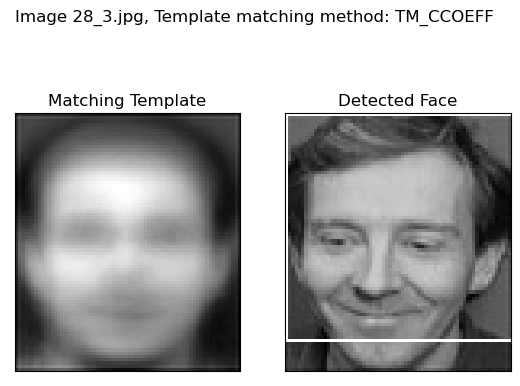

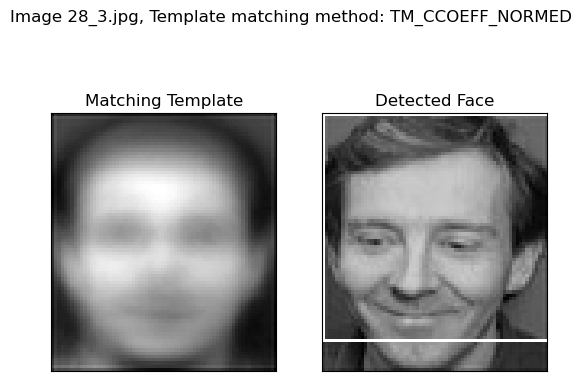

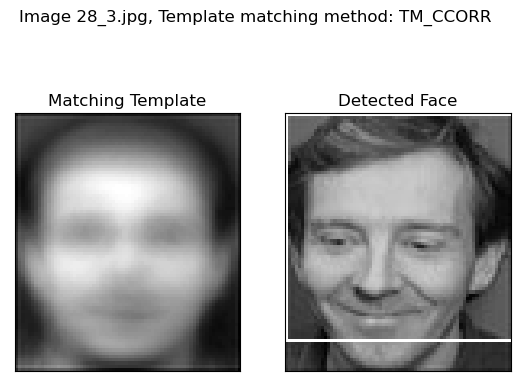

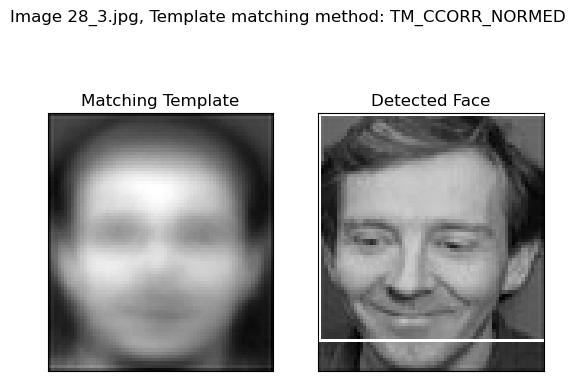

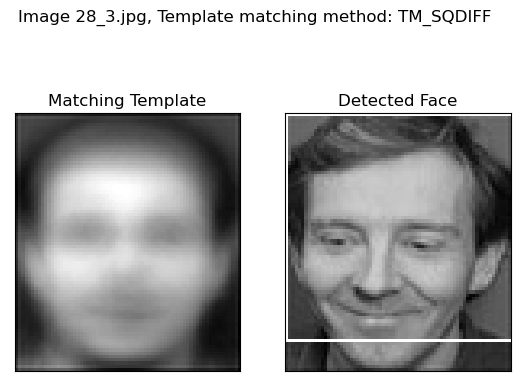

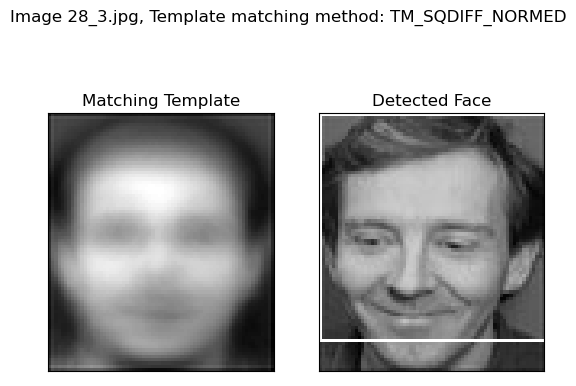

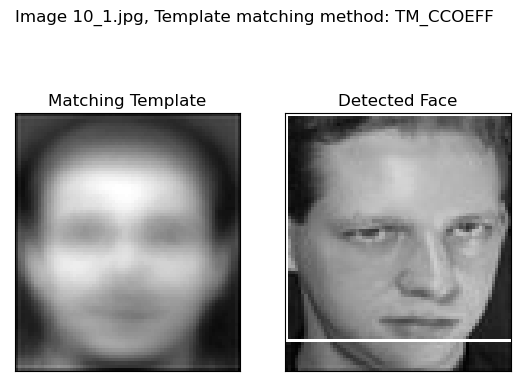

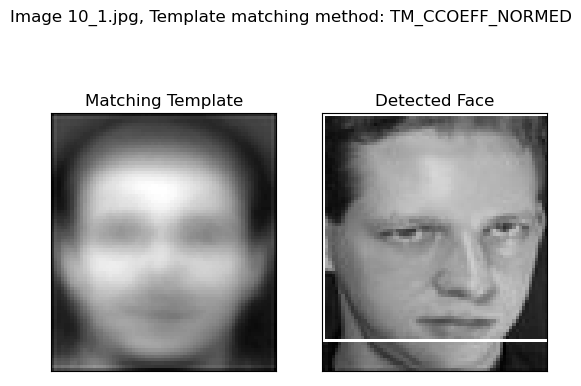

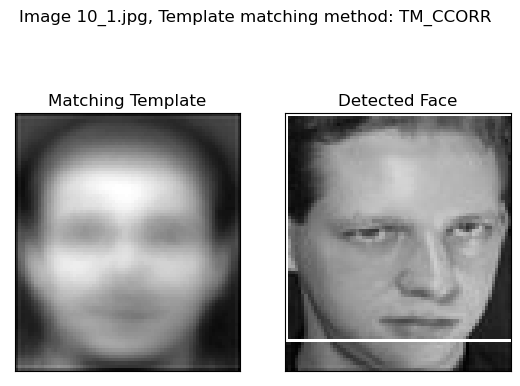

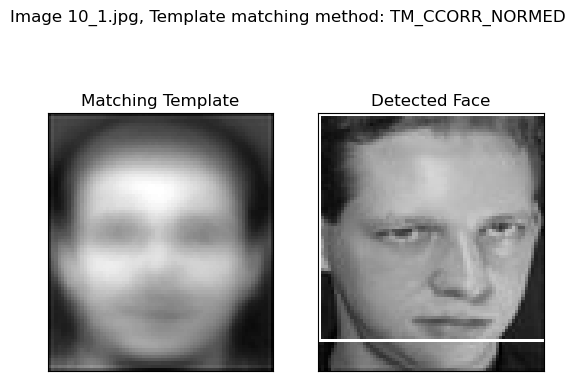

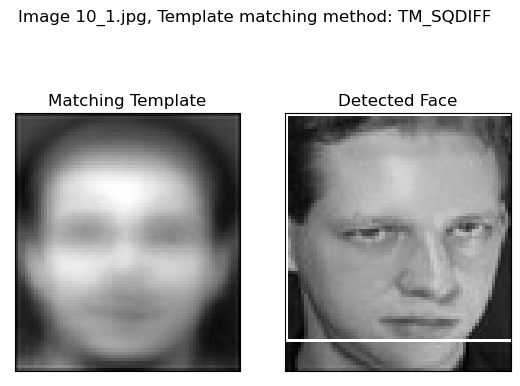

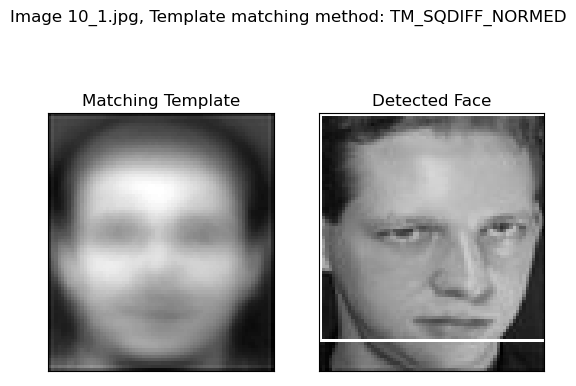

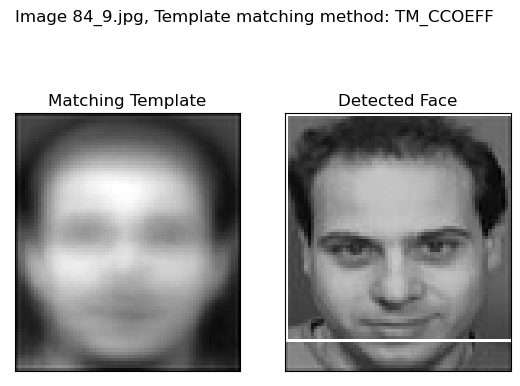

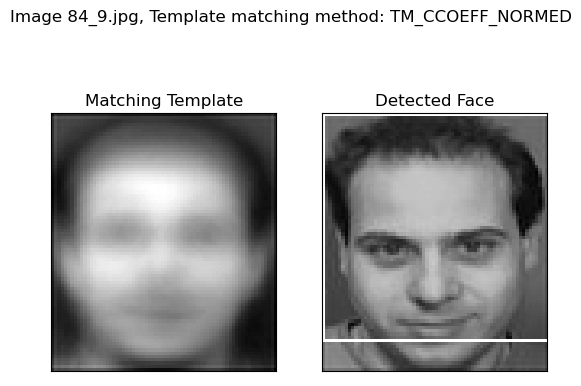

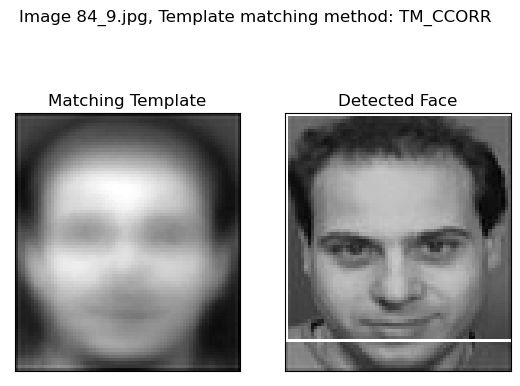

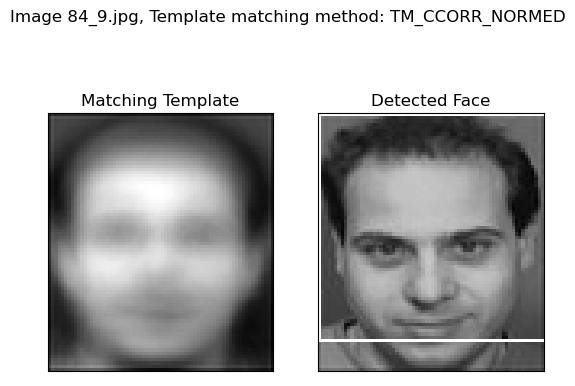

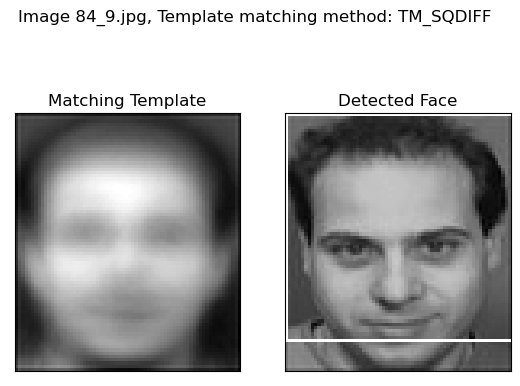

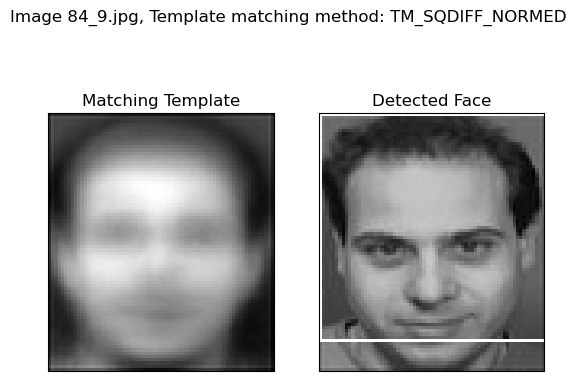

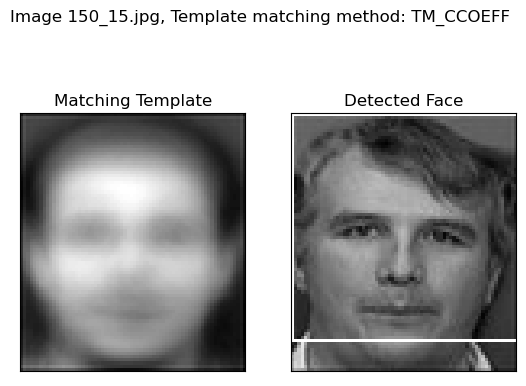

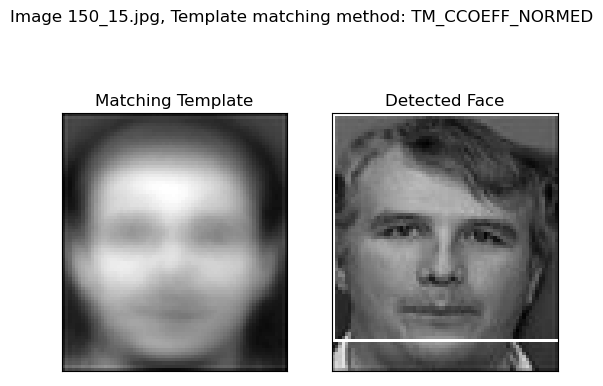

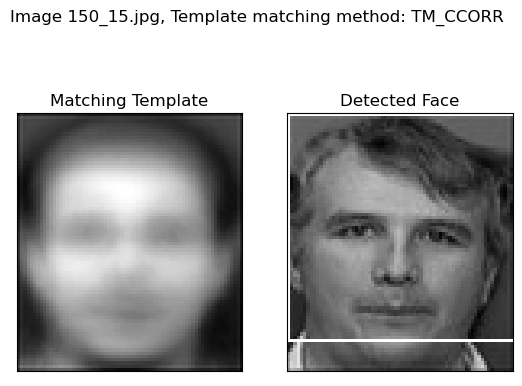

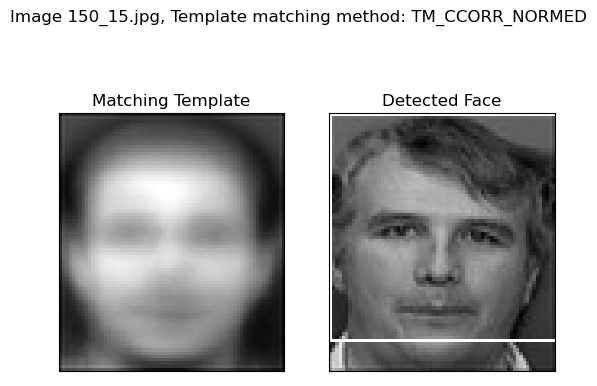

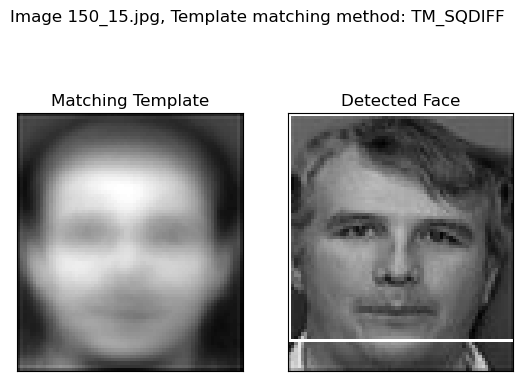

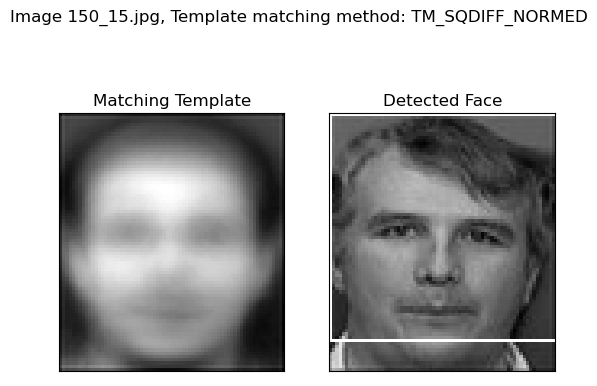

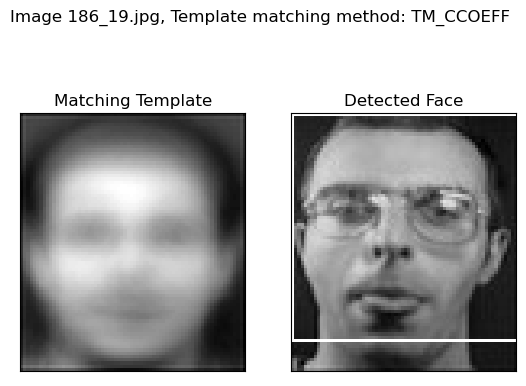

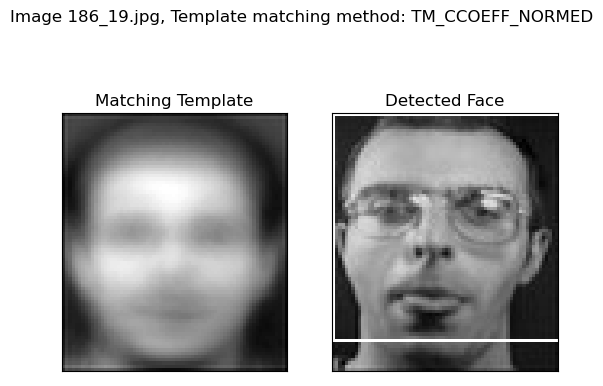

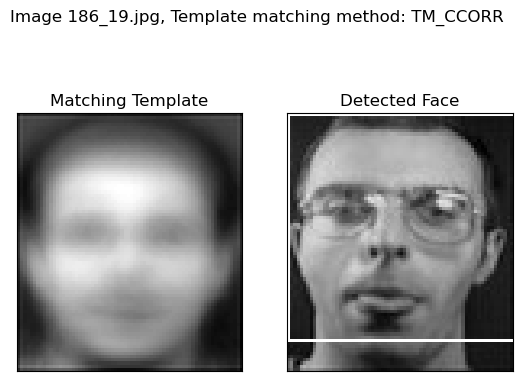

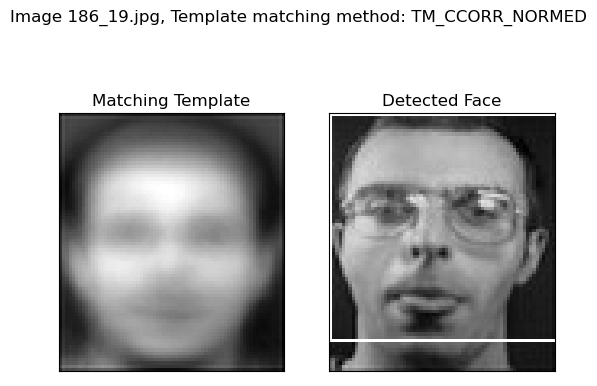

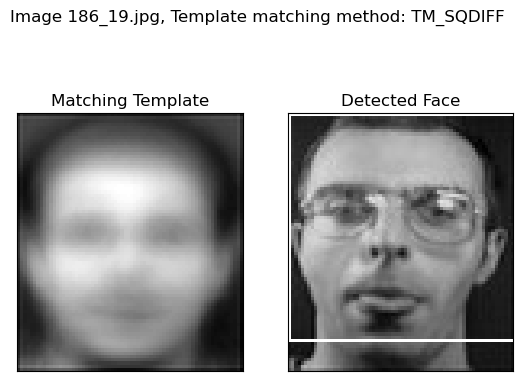

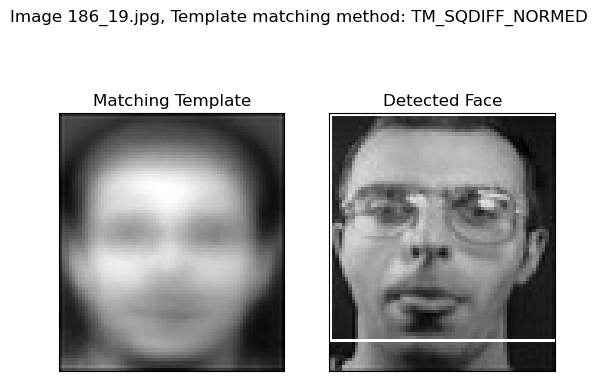

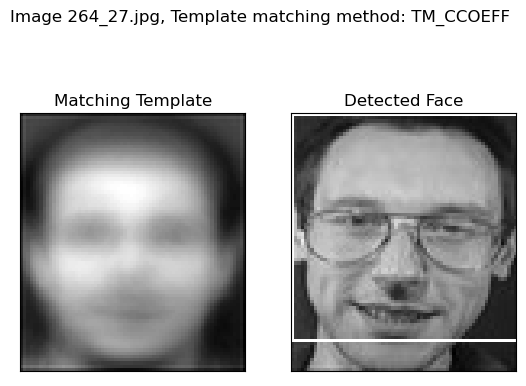

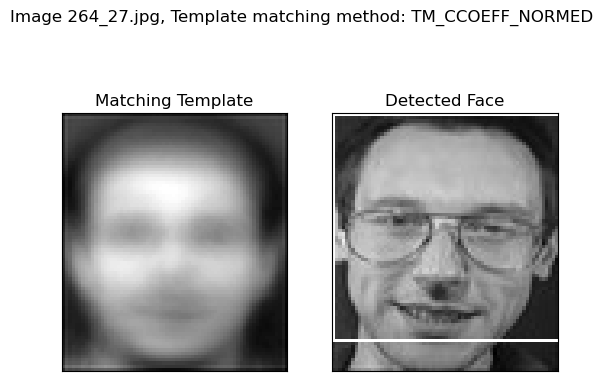

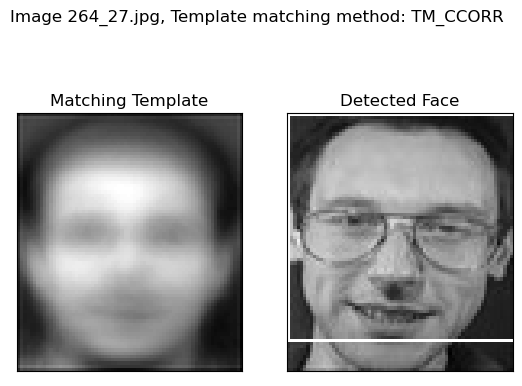

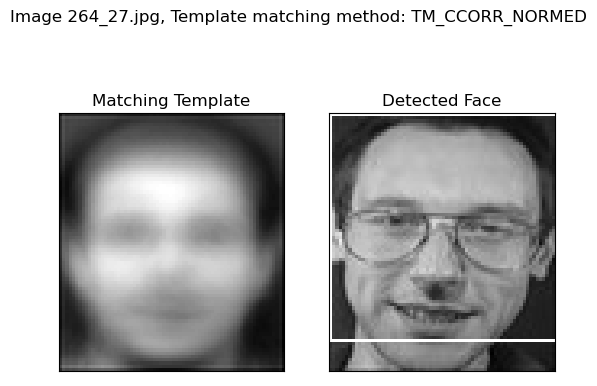

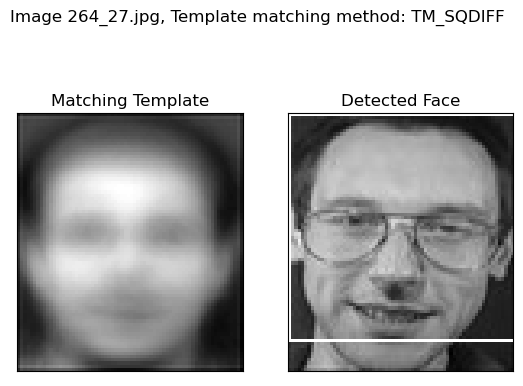

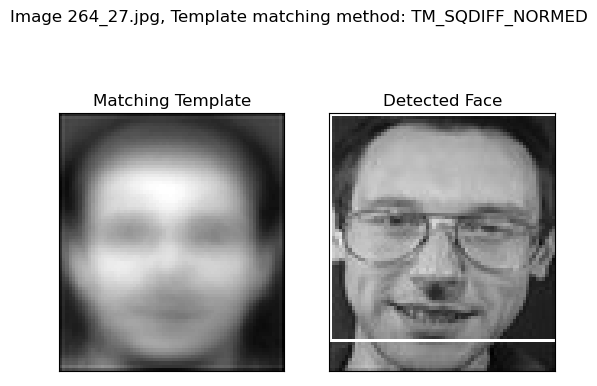

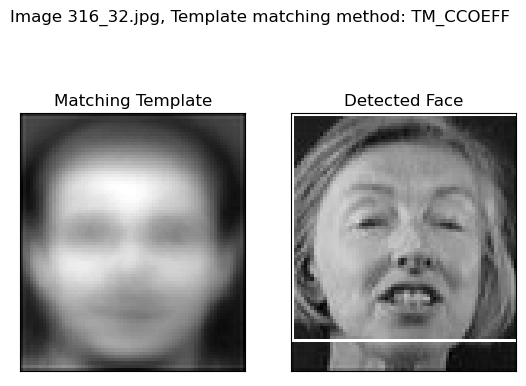

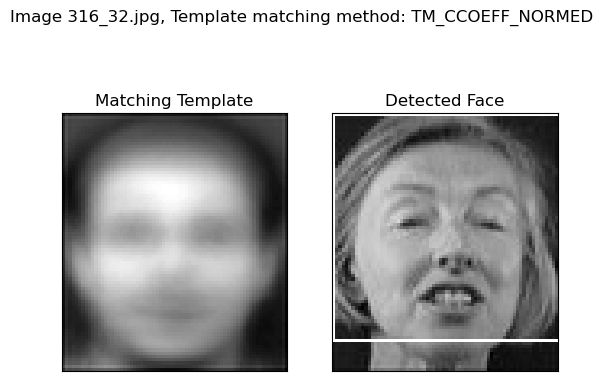

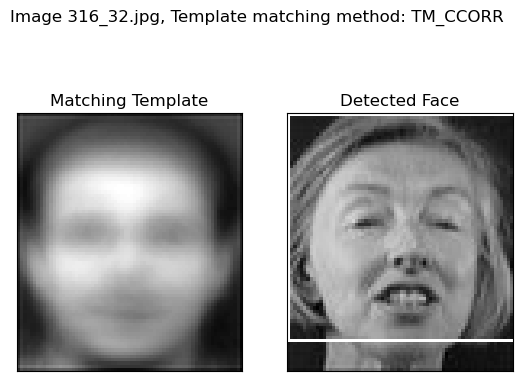

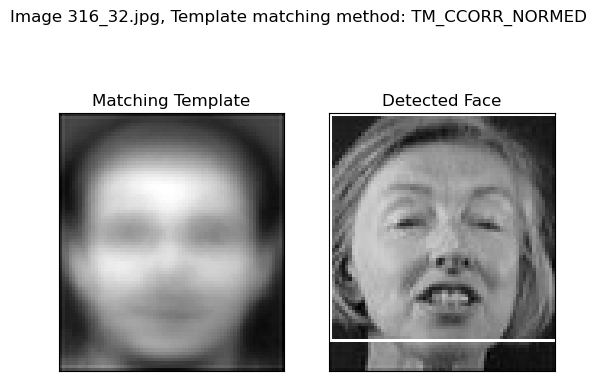

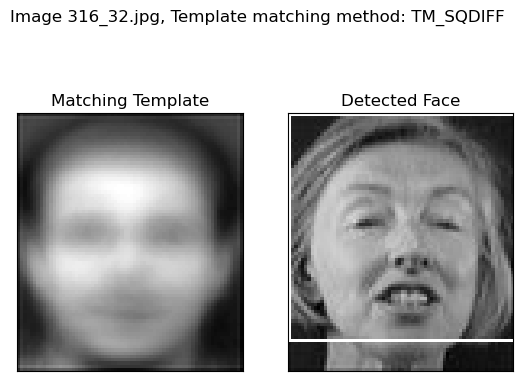

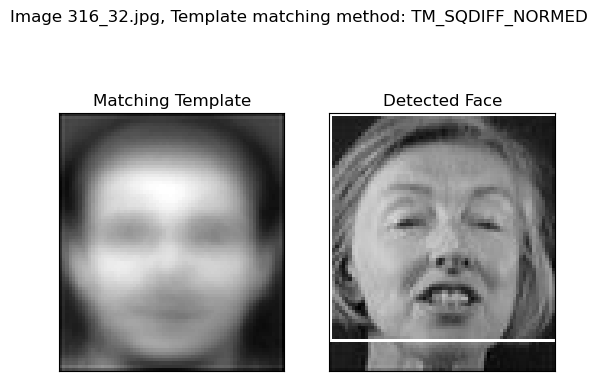

In [6]:
zad2()

Wnioski:
* Wszytkie cechy obrazów z ORL zostały zagregowane do uzyskania wzorca. 
* Metodą okna przesuwnego zostały wyszukane twarze na obrazach testowych.
* Pomimo zastosowania różnych metod template matchingu wszystkie twarze zostały wykryte prawidłowo.
* Wszytkie obrazy testowe mają mniej więcej w takim samym miejscu umiejscowione oczy, nos oraz usta. To ułatwiło eksperyment w wykrywaniu twarzy na obrazie, ponieważ wszystkie z nich były podobne do obrazu wzorcowego.